# Automated Accounting

El evento de asociar un pago o cobro con un documento pendiente de pagar o de cobrar se llama conciliación bancaria o liquidación de facturas. Al marcar como pagada una factura, esta genera un evento en contabilidad llamado asiento.

El siguiente notebook consistirá en plantear y desarrollar las técnicas/modelo útiles para conseguir efectuar lo anterior de manera automática, relacionando las facturas y transacciones o dejando transacciones sin relación porque son asientos directos.

* **No todas las transacciones bancarias pagan una factura**. Por ejemplo, un pago de una comisión, de las nóminas, de un impuesto... no se gestiona con un documento asociado y se realiza un asiento directo contra una cuenta contable.

* **Una transacción bancaria puede pagar N facturas**

* **Varias transacciones bancarias pueden pagar una factura**. Por ejemplo, si se hace un pago parcial de una factura y luego te abonan el resto.

* **Una transacción bancaria puede dividirse**. Por ejemplo, si pagas una factura en otra divisa, la diferencia de tipo de cambio te la llevas a una cuenta contable. O si pagas una comisión por haber pagado esa factura.


#### Transactions

Extracto de transacciones bancarias (transactions.csv) de diferentes cuentas corrientes de un cliente ficticio.

- id: identificador único en la base de datos
- fecha: fecha de valor de la transacción bancaria
- importe: cantidad de la transacción bancaria. (-) denota salida de dinero, (+) entrada
- concepto: concepto de la transacción
- banco: banco origen de la transacción
- divisa: divisa de la transacción
- categoria: categoría de tesorería de la transacción bancaria


#### Invoices

Extracto de documentos (facturas y remesas) pendientes de pagar y de cobrar leidos del sistema de contabilidad del cliente.

- id: identificador del documento correspondiente
- fecha_vencimiento: fecha de vencimiento de dicha factura, denota el último día en el que se puede pagar y cobrar (teóricamente).
- nombre_cliente: nombre del cliente o proveedor al que está asociada esa factura. Las remesas tienen por defecto el cliente "REMESASBANCOS".
- fecha_emision: fecha en la que se emitió el documento
- importe: cantidad del documento. (-) denota salida de dinero, (+) entrada

* Muchas empresas pagan N días determinados al mes, por lo que es muy común ver facturas vencidas pagándose después, porque se reciben en los días de pago de tu cliente o las pagas en tu día de pago mensual.


**Algoritmo de contabilización**

1. **Pre-procesamiento**: ¿Cómo harías para relacionar las transacciones bancarias con las facturas? Aplica las técnicas de limpieza, normalización, etc que consideres que ayudan para la relación.

2. **Relación**: ¿Cómo harías para tener en cuenta todos los casos, 1:N, 1:1, N:1, parciales? Desarrolla tu propio método para establecer relaciones entre ambos datasets a fin de cerrar los documentos pendientes.


# Solución

#### Inicialización del proceso, carga de los datasets y primera visualización de los datos

In [106]:
import pandas as pd
from datetime import timedelta
import os
from typing import Dict, List, Tuple, Union

# Cargar datos
invoices = pd.read_csv("invoices.csv")
transactions = pd.read_csv("transactions.csv")


In [108]:
print('FACTURAS', '\n', invoices.head())
print('\n')
print('TRANSACCIONES', '\n',transactions.head())


FACTURAS 
            id fecha_vencimiento divisa    nombre_cliente fecha_emision  \
0    10002183        2022-10-04    EUR     REMESASBANCOS    2022-10-04   
1  FSABV-2679        2023-03-14    EUR  Pluvisilva, S.L.    2022-12-14   
2    10002205        2022-10-28    EUR     REMESASBANCOS    2022-10-28   
3    10002227        2022-11-30    EUR     REMESASBANCOS    2022-11-30   
4    10002238        2022-12-19    EUR     REMESASBANCOS    2022-12-19   

    importe            concepto  
0  -9269,25   Remesa 04-10-2022  
1     -2856  Honorarios 4T 2022  
2  -2674,69   Remesa 28-10-2022  
3  -2674,69   Remesa 30-11-2022  
4  -2447,42   Remesa 19-12-2022  


TRANSACCIONES 
     id   importe       fecha  \
0  141   -5722,3  2022-12-20   
1   92     -4488  2022-10-04   
2  244   -3739,9  2022-12-20   
3  240  -2861,33  2022-10-04   
4   18     -2856  2022-10-04   

                                            concepto            banco divisa  \
0                      TRANSFERENCIA A FAVOR DE M

In [109]:
print('FACTURAS')
invoices.info()
print('\n' 'TRANSACCIONES')
transactions.info()

FACTURAS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 156 non-null    object
 1   fecha_vencimiento  156 non-null    object
 2   divisa             156 non-null    object
 3   nombre_cliente     152 non-null    object
 4   fecha_emision      156 non-null    object
 5   importe            156 non-null    object
 6   concepto           156 non-null    object
dtypes: object(7)
memory usage: 8.7+ KB

TRANSACCIONES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         285 non-null    int64 
 1   importe    285 non-null    object
 2   fecha      285 non-null    object
 3   concepto   285 non-null    object
 4   banco      285 non-null    object
 5   divisa     285 non-null    

In [110]:
invoices.describe()

,id,fecha_vencimiento,divisa,nombre_cliente,fecha_emision,importe,concepto
count,156,156,156,152,156,156,156
unique,156,67,1,61,58,114,143
top,10002183,2022-12-01,EUR,REMESASBANCOS,2022-10-01,"-49,13",Kilos de Carton
freq,1,18,156,11,18,3,4


In [111]:
transactions[[col for col in transactions.columns if col != 'id']].describe()

,importe,fecha,concepto,banco,divisa,categoria
count,285,285,285,285,285,285
unique,218,63,231,3,1,18
top,"108,9",2022-10-04,RECIBO /SV Internet S.L.,Caixabank,EUR,Pago Proveedores
freq,4,19,11,216,285,153


#### Pre-procesamiento de las datos

* Normalización de nombres
* Creación de un identificador único para todas las facturas
* EDA

In [112]:
def normalize_names(dataframe: pd.DataFrame, column_name: str) -> None:
    """
    Normalize the values in the specified column of a dataframe.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the column to be normalized.
    column_name (str): The name of the column to be normalized.

    Returns:
    None
    """
    # Convierte los nombres a minúsculas
    dataframe[column_name] = dataframe[column_name].str.lower()
    # Elimina espacios en blanco al principio y al final
    dataframe[column_name] = dataframe[column_name].str.strip()
    # Remueve caracteres especiales o acentos
    dataframe[column_name] = dataframe[column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Normalizar 'nombre_cliente', 'concepto' y 'id' en invoices
normalize_names(invoices, 'nombre_cliente')
normalize_names(invoices, 'concepto')
normalize_names(invoices, 'id')

# Normalizar 'concepto' en transactions
normalize_names(transactions, 'concepto')

Entre las primeras cosas que realizamos es crear una nueva columna en los datos de las facturas para usar como identificador único

In [113]:
if not os.path.isfile('invoices_with_hash.csv'):    
    # Se crea un "hash" de cada factura basado en su "id" y "nombre_cliente"
    invoices['hash'] = invoices['id'].astype(str) + '##' + invoices['nombre_cliente'].astype(str)

    # Guarda el conjunto de datos actualizado
    column_order = ['hash'] + [col for col in invoices.columns if col != 'hash']
    invoices = invoices[column_order]
    invoices.to_csv('invoices_with_hash.csv', index=False)
else:
    invoices = pd.read_csv("invoices_with_hash.csv")

In [114]:
invoices['fecha_vencimiento'] = pd.to_datetime(invoices['fecha_vencimiento'])
invoices['fecha_emision'] = pd.to_datetime(invoices['fecha_emision'])
transactions['fecha'] = pd.to_datetime(transactions['fecha'])

invoices['importe'] = invoices['importe'].map(lambda val: val.replace(',', '.')).astype(float)
transactions['importe'] = transactions['importe'].map(lambda val: val.replace(',', '.')).astype(float)


#### EDA
Ahora que tenemos los tipos de datos "correctos" podemos volver a observar características de nuestros datos

In [115]:
print(invoices.describe())

print(transactions.describe())

            importe
count    156.000000
mean     202.697821
std     3363.887059
min    -9269.250000
25%     -262.552500
50%      -46.865000
75%       -7.600000
max    24653.990000
               id        importe
count  285.000000     285.000000
mean   143.000000     648.519965
std     82.416625    9475.016713
min      1.000000   -8290.050000
25%     72.000000    -415.590000
50%    143.000000     -52.300000
75%    214.000000      -7.600000
max    285.000000  148459.000000


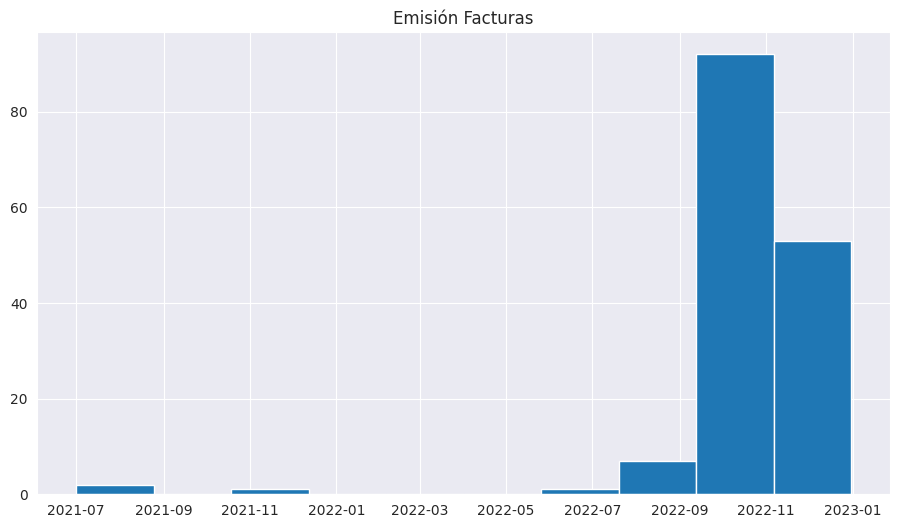

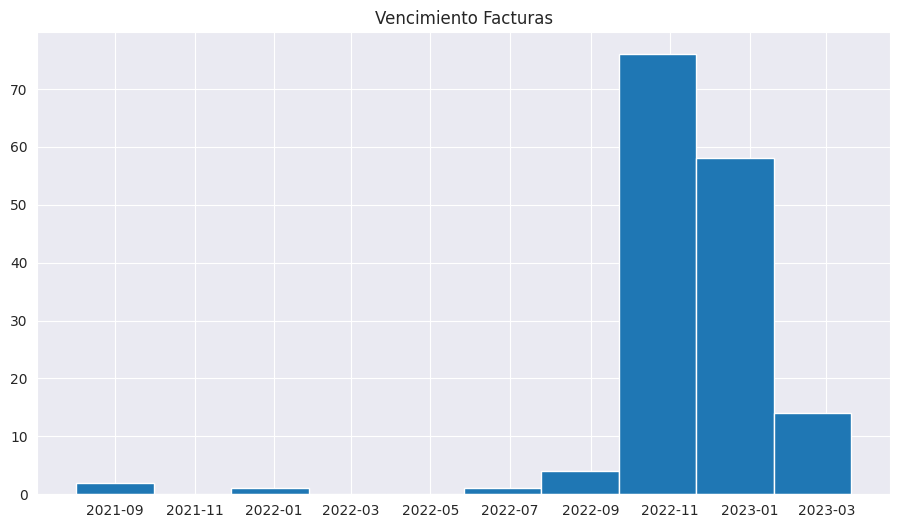

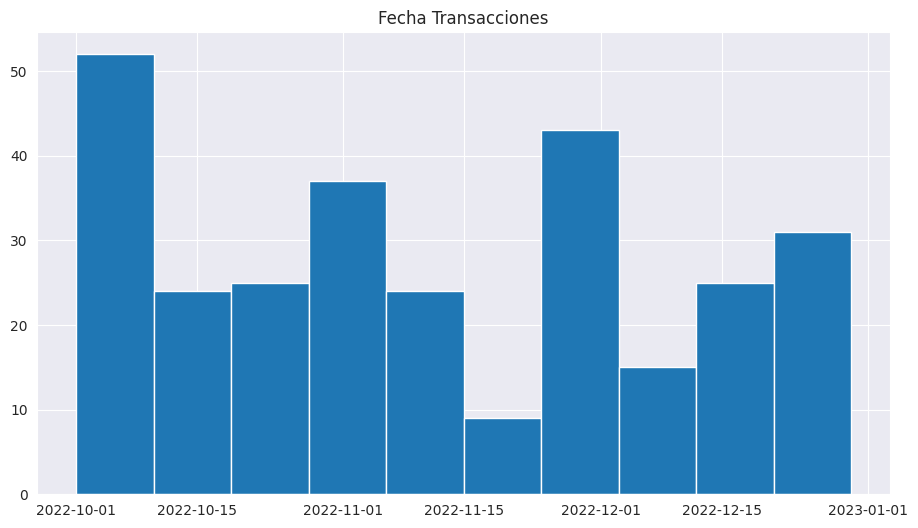

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

plt.figure(figsize=(11,6))
invoices['fecha_emision'].hist()
plt.title("Emisión Facturas")
plt.show()

plt.figure(figsize=(11,6))
invoices['fecha_vencimiento'].hist()
plt.title("Vencimiento Facturas")
plt.show()

plt.figure(figsize=(11,6))
transactions['fecha'].hist()
plt.title("Fecha Transacciones")
plt.show()

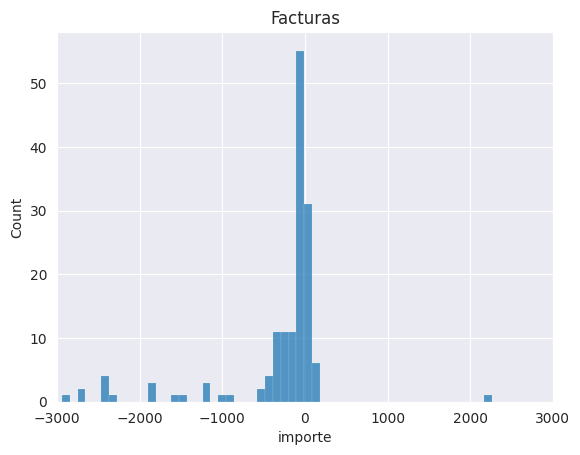

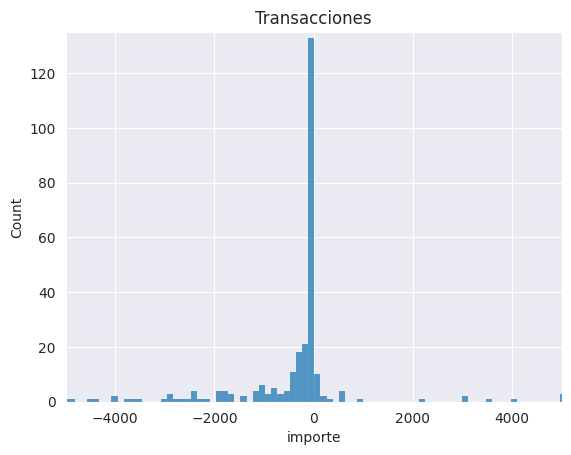

In [117]:
fig, ax = plt.subplots()
sns.histplot(invoices['importe'],  ax=ax)
ax.set_title("Facturas")
ax.set_xlim(-3000, 3000)
ax.set_ylim(0, 58)
plt.show()

fig, ax = plt.subplots()
sns.histplot(transactions['importe'],  ax=ax)
ax.set_title("Transacciones")
ax.set_xlim(-5000, 5000)
ax.set_ylim(0, 135)
plt.show()


#### Funciones auxiliares para relacionar una factura con sus respectivas transacciones

In [118]:
def filter_transactions_by_date(transactions, start_date, end_date):
    """
    Filter transactions based on the date range.

    Parameters:
    transactions (pd.DataFrame): The dataframe containing the transactions.
    start_date: The start date of the range.
    end_date: The end date of the range.

    Returns:
    pd.DataFrame: The filtered transactions.
    """
    return transactions[
        (transactions['fecha'] <= end_date) &
        (transactions['fecha'] >= start_date)
    ]


def filter_transactions_by_amount(transactions, amount):
    """
    Filter transactions based on the amount.

    Parameters:
    transactions (pd.DataFrame): The dataframe containing the transactions.
    amount (float): The amount to filter by.

    Returns:
    pd.DataFrame: The filtered transactions.
    """
    return transactions[transactions['importe'] == amount]

def find_nearest_transaction(transactions):
    """
    Find the nearest transaction to the invoice issue date.

    Parameters:
    transactions (pd.DataFrame): The dataframe containing the transactions.

    Returns:
    pd.DataFrame: The nearest transaction(s).
    """
    if len(transactions) > 1:
        return transactions[transactions['fecha'] == transactions['fecha'].min()]
    else:
        return transactions

def filter_transaction_by_keyword(transactions, keyword):
    """
    Filter transactions based on a keyword.

    Parameters:
    transactions (pd.DataFrame): The dataframe containing the transactions.
    keyword (str): The keyword to filter by.

    Returns:
    pd.DataFrame: The filtered transactions.
    """
    return transactions[transactions['concepto'].str.contains(keyword)]


Construimos dos métodos distintos para obtener candidatos potenciales a relacionarse con un factura dada.

In [120]:
def find_relative_transactions_comp(invoice: pd.Series, transactions: pd.DataFrame) -> pd.DataFrame:
    """
    Find potential transactions related to the given invoice.

    Parameters:
    invoice (pd.Series): The dataframe representing the invoice.
    transactions (pd.DataFrame): The dataframe containing the transactions.

    Returns:
    pd.DataFrame: The relevant transaction(s) related to the invoice.
    """
    # Filtrar transacciones realizadas entre el vencimiento y la emisión del invoice
    potential_transactions = filter_transactions_by_date(
        transactions,
        invoice['fecha_emision'],
        invoice['fecha_vencimiento']
    )

    # Filtrar por coincidencia exacta de importes
    relevant_transactions = filter_transactions_by_amount(
        potential_transactions,
        invoice['importe']
    )

    # Relacionar la factura con la transacción de fecha más cercana a su emisión
    relevant_transactions = find_nearest_transaction(relevant_transactions)

    # Si hay más de una transaccion relevante nos quedamos con la de id más alto
    if len(relevant_transactions) > 1:
        relevant_transactions[relevant_transactions['id'] == relevant_transactions['id'].max()]

    return relevant_transactions


In [121]:
def find_relative_transactions_simp(invoice: pd.Series, transactions: pd.DataFrame) -> pd.DataFrame:
    """
    Find transactions related to the given invoice based on the invoice id.

    Parameters:
    invoice (pd.Series): The dataframe representing the invoice.
    transactions (pd.DataFrame): The dataframe containing the transactions.

    Returns:
    pd.DataFrame: The relevant transaction(s) related to the invoice.
    """
    # Relacionar la factura con la transacción que contenga el id de la factura
    relevant_transactions = filter_transaction_by_keyword(
        transactions,
        keyword=invoice['id']
    )
    return relevant_transactions

Ahora necesitamos un método que pueda decidir con qué grupo de transacciones nos debemos quedar para establecer la relación con una factura dada.

In [122]:
def decide_transactions(invoice: pd.Series, candidate_from_comp: pd.DataFrame, candidate_from_simp: pd.DataFrame) -> pd.DataFrame:
    """
    Decide which candidate transactions to select based on the invoice amount.

    Parameters:
    invoice (pd.Series): The dataframe representing the invoice.
    candidate_from_comp (pd.DataFrame): The candidate transaction(s) from the compound method.
    candidate_from_simp (pd.DataFrame): The candidate transaction(s) from the simple method.

    Returns:
    pd.DataFrame: The selected transaction(s) based on the invoice amount.
    """
    if sum(candidate_from_simp['importe']) == invoice['importe']:
        return candidate_from_simp
    else:
        return candidate_from_comp

#### Funcion principal para procesar todas las facturas y encontrar todas las relaciones respectivas

In [123]:
def process_invoices_transactions(invoices: pd.DataFrame, transactions: pd.DataFrame) -> Dict[Tuple[str], List[int]]:
    """
    Process invoices and transactions to find relations and return a dictionary of detected relations.

    Parameters:
    invoices (pd.DataFrame): The dataframe containing the invoices.
    transactions (pd.DataFrame): The dataframe containing the transactions.

    Returns:
    Dict[Tuple[str, float], List[int]]: A dictionary mapping invoice hashes to relevant transaction IDs.
    """
    counter = 0
    detected_relations = {}

    for _, invoice in invoices.iterrows():
        candidates_transactions_1 = find_relative_transactions_comp(invoice, transactions)
        candidates_transactions_2 = find_relative_transactions_simp(invoice, transactions)

        relevant_transactions = decide_transactions(invoice, candidates_transactions_1, candidates_transactions_2)

        key = tuple(invoice['hash'] if pd.isna(invoice['hash']) else [invoice['hash']])
        # Se almacenan la relaciones en el diccionario
        detected_relations[key] = relevant_transactions['id'].tolist()

        counter += len(relevant_transactions)

    print(f'Se encontraron {counter} relaciones para {len(invoices)} facturas')
    return detected_relations

# Uso de la función principal
detected_relations = process_invoices_transactions(invoices, transactions)


Se encontraron 87 relaciones para 156 facturas


Ahora se crea un método para guardar a disco el resultado de nuestra función principal con todas las relaciones encontradas. 

El formato de la salida .json es el siguiente:

```
{
    <relation_id>: {
            'invoice_list': [invoice_1, invoice_2, ...], 
            'transaction_list': [transaction_1, transaction_2, transaction_3, ...]
    },
}
```

In [124]:
import json

def parse_output(relations: Dict[Tuple[str], List[int]]) -> Dict[int, Dict[str, List[Union[str, int]]]]:
    """
    Parse the relations dictionary into a specific output format.

    Parameters:
    relations (Dict[Tuple[str], List[int]]): The dictionary of relations.

    Returns:
    Dict[int, Dict[str, List[Union[str, int]]]]: The parsed output dictionary.
    """
    output_dict = {}
    index = 1

    for keys, values in relations.items():
        invoice_list = list(keys)
        transaction_list = list(values)

        output_dict[index] = {
            'invoice_list': invoice_list,
            'transaction_list': transaction_list
        }
        index += 1
    return output_dict

def saveresults2json(results_dict: Dict[int, Dict[str, List[Union[str, int]]]], name_file_output: str) -> None:
    """
    Save the results dictionary to a JSON file.

    Parameters:
    results_dict (Dict[int, Dict[str, List[Union[str, int]]]]): The dictionary of results.
    name_file_output (str): The name of the output JSON file.

    Returns:
    None
    """
    with open(name_file_output, "w") as fp:
        json.dump(results_dict, fp)

parsed_dict = parse_output(detected_relations)
saveresults2json(parsed_dict, 'detected_relations_COMPLETE.json')


#### STEP2 - Incluisón del hyperparametro: **date_window** en el método compuesto para considerar transacciones por _facturas vencidas_

In [125]:
def filter_transactions_by_date(transactions, start_date, end_date, date_window):
    """
    Filter transactions based on the date range.

    Parameters:
    transactions (pd.DataFrame): The dataframe containing the transactions.
    start_date: The start date of the range.
    end_date: The end date of the range.
    date_window: The date window to use in the filter.

    Returns:
    pd.DataFrame: The filtered transactions.
    """
    return transactions[
        (transactions['fecha'] - date_window <= end_date) &
        (transactions['fecha'] >= start_date)
    ]

# Método compuesto para la búsqueda de transacciones potenciales
def find_relative_transactions_comp(invoice: pd.Series, transactions: pd.DataFrame, date_window: timedelta) -> pd.DataFrame:
    """
    Find potential transactions related to the given invoice.

    Parameters:
    invoice (pd.Series): The dataframe representing the invoice.
    transactions (pd.DataFrame): The dataframe containing the transactions.
    date_window (timedelta): The date window to use in the filter.

    Returns:
    pd.DataFrame: The relevant transaction(s) related to the invoice.
    """
    potential_transactions = filter_transactions_by_date(
        transactions,
        invoice['fecha_emision'],
        invoice['fecha_vencimiento'],
        date_window
    )
    relevant_transactions = filter_transactions_by_amount(
        potential_transactions,
        invoice['importe']
    )
    relevant_transactions = find_nearest_transaction(relevant_transactions)
    if len(relevant_transactions) > 1:
        relevant_transactions[relevant_transactions['id'] == relevant_transactions['id'].max()]
    return relevant_transactions


In [126]:
# Funcion principal para procesar todas las facturas
def process_invoices_transactions(invoices: pd.DataFrame, transactions: pd.DataFrame, days_window: int=0) -> Dict[Tuple[str], List[int]]:
    """
    Process invoices and transactions to find relations and return a dictionary of detected relations.

    Parameters:
    invoices (pd.DataFrame): The dataframe containing the invoices.
    transactions (pd.DataFrame): The dataframe containing the transactions.
    days_window(int): The number of days to use in the filter.

    Returns:
    Dict[Tuple[str, float], List[int]]: A dictionary mapping invoice hashes to relevant transaction IDs.
    """
    date_window = timedelta(days=days_window)
    counter = 0
    detected_relations = {}

    for _, invoice in invoices.iterrows():
        candidates_transactions_1 = find_relative_transactions_comp(invoice, transactions, date_window)
        candidates_transactions_2 = find_relative_transactions_simp(invoice, transactions)

        relevant_transactions = decide_transactions(invoice, candidates_transactions_1, candidates_transactions_2)

        key = tuple(invoice['hash'] if pd.isna(invoice['hash']) else [invoice['hash']])
        # Se almacenan la relaciones en el diccionario
        detected_relations[key] = relevant_transactions['id'].tolist()

        counter += len(relevant_transactions)

    print(f'Se encontraron {counter} relaciones para {len(invoices)} facturas')
    return detected_relations

# Uso de la función principal
detected_relations = process_invoices_transactions(invoices, transactions, days_window=1)

# Guardar a disco los resultados
parsed_dict = parse_output(detected_relations)
saveresults2json(parsed_dict, 'detected_relations_HYPERPARAM_COMPLETE.json')

Se encontraron 89 relaciones para 156 facturas


## Test

Construimos un conjunto de test compuesto por 26 facturas y 40 transacciones. 

Entre las mismas incluímos 23 RELACIONES VALIDAS ENTRE 25 FACTURAS Y 28 TRANSACCIONES, de las cuales 18 son **1:1**, 3 son del tipo **1:N**, 1 es **N:1** y 1 es **parcial**. 

In [127]:
relations = {
    ('fsabv-2363##mitanni consultores asoc, s.l.p.', ): (221, ),
    ('fsabv-2632##pepemobile sl', ): (100, ),
    ('fsabv-2630##mitanni consultores asoc, s.l.p.', ): (243, ),
    ('fsabv-2651##masvoz telecomunicaciones interactivas, s.l.', ): (265, ),
    ('fsabv-2518##masvoz telecomunicaciones interactivas, s.l.', ): (256, ),
    ('fsabv-2662##aigues de barcelona, empresa metropolitana de gestio aigua', ): (107, ),
    ('fvi-45##eloelo', ): (152, ),
    ('fvi-47##medios', ): (24, ),
    ('fve-12855##equipzilla, s.l.', ): (134, ),
    ('fsabv-2369##nan', ): (39, ),
    ('fsabv-2564##nan', ): (271, ),
    ('fsabv-2639##nan', ): (73, ),
    ('fsabv-2497##telefonica moviles espana, s.a.', ): (57, ),
    ('fsabv-2200##tomas gil', ): (112, ),
    ('fsabv-2553##tomas gil', ): (143, ),
    ('fsabv-2285##tomas gil', ): (31, ),
    ('fve-12850##property technology services, s.l.', ): (33, ),
    ('fve-12852##property technology services, s.l.', ): (241, ),
    ('feqz-75##gam espana servicios de maquinaria s.l.u.',
      'feqz-74##gam espana servicios de maquinaria s.l.u.',
      'feqz-85##gam espana servicios de maquinaria s.l.u.'): (3, ),
    ('10002183##remesasbancos', ): (30, 81, 18, 92),
    ('10002227##remesasbancos', ): (188, 124),
    ('10002238##remesasbancos', ): (262, 55),
    ('fvi-48##maks inventada sl', ): (122, )
}

Cargamos el conjunto de TEST y realizamos el pre-procesamiento de los datos.

In [128]:
import pandas as pd
from datetime import timedelta

invoices_test = pd.read_csv("invoices_TEST.csv")
transactions_test = pd.read_csv("transactions_TEST.csv")

normalize_names(invoices_test, 'hash')
normalize_names(invoices_test, 'nombre_cliente')
normalize_names(invoices_test, 'id')
normalize_names(invoices_test, 'concepto')
normalize_names(transactions_test, 'concepto')

invoices_test['fecha_vencimiento'] = pd.to_datetime(invoices_test['fecha_vencimiento'])
invoices_test['fecha_emision'] = pd.to_datetime(invoices_test['fecha_emision'])
transactions_test['fecha'] = pd.to_datetime(transactions_test['fecha'])
invoices_test['importe'] = invoices_test['importe'].map(lambda val: val.replace(',', '.')).astype(float)
transactions_test['importe'] = transactions_test['importe'].map(lambda val: val.replace(',', '.')).astype(float)


##### Contabilizamos la cantidad de relaciones encontradas correctamente para cierto valor de nuesto hyperparametro *date_window*

In [131]:
detected_relations_test = process_invoices_transactions(invoices_test, transactions_test, days_window=15)

# Inicializamos el contador de relaciones correctas
check_relations = 0

# Iteramos sobre las relaciones en el diccionario de relaciones
print('\n')
for invoice, expected_transactions in relations.items():
    # Verificamos si las transacciones detectadas coinciden con las esperadas
    detected_transactions = detected_relations_test.get(invoice, [])

    if set(detected_transactions) == set(expected_transactions):
        print(f"Relaciones para {invoice} detectadas correctamente.")
        check_relations += 1

# Se muestra el resultado final
print('\n')
print(f"Total de relaciones correctas: {check_relations} de {len(relations)}")

Se encontraron 17 relaciones para 26 facturas


Relaciones para ('fsabv-2363##mitanni consultores asoc, s.l.p.',) detectadas correctamente.
Relaciones para ('fsabv-2632##pepemobile sl',) detectadas correctamente.
Relaciones para ('fsabv-2630##mitanni consultores asoc, s.l.p.',) detectadas correctamente.
Relaciones para ('fsabv-2651##masvoz telecomunicaciones interactivas, s.l.',) detectadas correctamente.
Relaciones para ('fsabv-2518##masvoz telecomunicaciones interactivas, s.l.',) detectadas correctamente.
Relaciones para ('fsabv-2662##aigues de barcelona, empresa metropolitana de gestio aigua',) detectadas correctamente.
Relaciones para ('fvi-45##eloelo',) detectadas correctamente.
Relaciones para ('fvi-47##medios',) detectadas correctamente.
Relaciones para ('fve-12855##equipzilla, s.l.',) detectadas correctamente.
Relaciones para ('fsabv-2369##nan',) detectadas correctamente.
Relaciones para ('fsabv-2564##nan',) detectadas correctamente.
Relaciones para ('fsabv-2639##nan',) detecta

# Ideas para abordar los casos restantes: _N:1_ y _parciales_.

**Relaciones N:1**

* Relaciones por Cliente o Concepto:

Se puedem armar conjuntos de facturas teniendo en cuenta el cliente y/o el concepto, también  de transacciones por el mismo nombre en el concepto y luego intentar relacionar cada grupo de facturas con el grupo correspondiente de transacciones. Esto podría manejar casos donde varias facturas están asociadas a un solo pago. 

* Observar el Importe Total:

Como un caso particular del anterior, si se tienen múltiples facturas para un mismo cliente y una transacción con un importe que coincide, sería posible establecer relación. También se puede establecer que se deban chequear posibles coincidencias entre las sumas dadas por todos los subconjuntos de estas facturas agrupadas por cliente y la transacción objetivo.

* Fecha y Monto:

De la misma forma que el primer punto pero relacionando las facturas y transacciones por la fecha y el monto para combinar las facturas y transacciones con fechas y montos cercanos. Esto a su vez podría abordar pagos parciales donde varias facturas comparten una transacción.

* Inclusión de un nuevo hiperparámetro: *tol_importe*:

Así como se incluyó el parámetro *date_window*, sería interesante incluir en la implementación del punto anterior un parámetro que permita una tolerancia a la hora de chequear que dos importes coinciden.




**Pagos Parciales**

* Conjuntos por ID y Cliente:

Se busca crear conjuntos de transacciones en función de palabras claves en el campo "concepto" para relacionarlos al ID de las facturas y los clientes. Si hay múltiples transacciones para una factura, se puede sumar los importes y comparar con el importe total de la factura y así establecer si es un pago parcial. Aquí nuevamente debemos chequear que las transacciones candidatas a ser pagos parciales deben ser realizadas en fechas "cercanas" al periodo de vigencia de la/s factura/s corespondiente.

* Explorar el "concepto" de las transacciones:

Si una factura se paga parcialmente, el concepto de la transacción puede indicar claramente que se trata de un pago parcial.

* Fechas y Montos:

Se pueden tomar las facturas que no relacionadas con transacciones de la forma 1:1 ni 1:N y considerar como sus potenciales candidatos a transacciones de pagos parciales todas aquellas transacciones por montos menores realizadas luego de su fecha de emisión. Luego se pueden utilizar los dos puntos anteriores para filtrar cuáles de esas transacciones pueden ser consideradas relevantes para ser pagos parciales.

